# Лабораторная работа №2: Векторизация текста

In [94]:
import re
import os
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from scipy.spatial.distance import cosine
from gensim.models import Word2Vec
import subprocess
import sys

packages = ['numpy', 'pandas', 'tqdm', 'scipy', 'gensim']
for package in packages:
    try:
        __import__(package)
    except ImportError:
        print(f"Установка {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])

In [95]:
def load_lemmas_from_tsv(file_path):
    lemmas = []
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if not line:  
                    continue
                parts = line.split('\t')
                if len(parts) >= 3:
                    lemma = parts[2]
                    lemmas.append(lemma)
    except FileNotFoundError:
        pass
    return lemmas

def load_documents_from_lab1(lab1_path):
    sentences = []
    
    for dataset_type in ['train', 'test']:
        dataset_path = os.path.join(lab1_path, dataset_type)
        if not os.path.exists(dataset_path):
            continue
            
        for class_name in os.listdir(dataset_path):
            class_path = os.path.join(dataset_path, class_name)
            if not os.path.isdir(class_path):
                continue
            
            for file_name in os.listdir(class_path):
                if file_name.endswith('.tsv'):
                    file_path = os.path.join(class_path, file_name)
                    lemmas = load_lemmas_from_tsv(file_path)
                    if lemmas:
                        sentences.append(lemmas)
    
    return sentences

lab1_path = "C:/Users/Paul/Projects/nlp-25/projects/pn-pren/lab1"
sentences = load_documents_from_lab1(lab1_path)

print(f"Загружено: {len(sentences)}")

Загружено: 127600


Матрица термин-документ

In [96]:
import string
from nltk.corpus import stopwords
import nltk
from collections import defaultdict
from scipy import sparse

english_stopwords = set(stopwords.words('english'))

def preprocess_lemmas(lemmas, stop_words=None):
    if stop_words is None:
        stop_words = english_stopwords
    return [l for l in lemmas if l and l not in stop_words and l not in string.punctuation]

def build_term_document_matrix(documents, min_freq=2):
    
    term_freq = defaultdict(int)
    for doc in documents:
        for term in set(doc):
            term_freq[term] += 1
    
    filtered_terms = {term: freq for term, freq in term_freq.items() if freq >= min_freq}
    term_index = {term: idx for idx, term in enumerate(sorted(filtered_terms.keys()))}
    
    row_indices, col_indices, data = [], [], []
    for doc_idx, doc in enumerate(documents):
        term_counts = defaultdict(int)
        for term in doc:
            if term in term_index:
                term_counts[term] += 1
        
        for term, count in term_counts.items():
            row_indices.append(doc_idx)
            col_indices.append(term_index[term])
            data.append(count)
    
    td_matrix = sparse.csr_matrix(
        (data, (row_indices, col_indices)),
        shape=(len(documents), len(term_index)),
        dtype=np.int32
    )
    
    return filtered_terms, term_index, td_matrix

sentences = [preprocess_lemmas(s) for s in sentences]
sentences = [s for s in sentences if s]

term_freq_dict, term_index_dict, td_matrix = build_term_document_matrix(sentences, min_freq=2)

print(td_matrix.shape)
print(f"Density: {td_matrix.nnz / (td_matrix.shape[0] * td_matrix.shape[1]) * 100:.4f}%")
print(f"Memory: {(td_matrix.data.nbytes + td_matrix.indices.nbytes + td_matrix.indptr.nbytes) / 1024**2:.2f} MB")

print(f"\nTop-20 terms:")
for term, freq in sorted(term_freq_dict.items(), key=lambda x: x[1], reverse=True)[:20]:
    print(f"  {term:20} : {freq:5}")

(127600, 39319)
Density: 0.0581%
Memory: 22.72 MB

Top-20 terms:
  39                   : 31696
  say                  : 27870
  new                  : 19107
  reuters              : 13725
  year                 : 13363
  u                    : 10098
  two                  :  9703
  company              :  9354
  first                :  9249
  ap                   :  9064
  one                  :  7987
  win                  :  7829
  report               :  7174
  world                :  7077
  make                 :  7052
  take                 :  6840
  game                 :  6706
  last                 :  6672
  week                 :  6668
  monday               :  6477


In [97]:
%pip install matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


nonzero_docs: 50


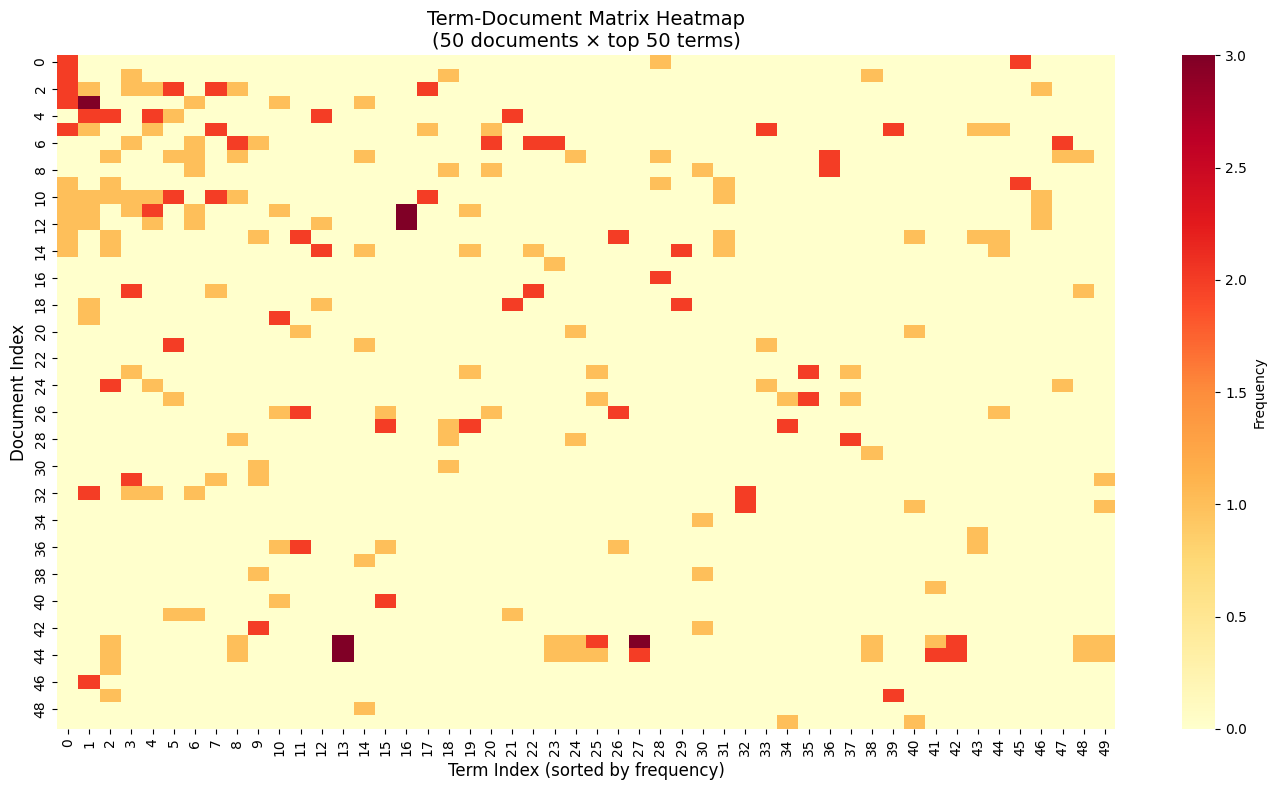

Density: 0.118000
Max value: 3

Top-10:
  1. reuters              (freq: 16)
  2. oil                  (freq: 16)
  3. new                  (freq: 13)
  4. market               (freq: 11)
  5. price                (freq: 10)
  6. economy              (freq: 10)
  7. say                  (freq: 8)
  8. stock                (freq: 8)
  9. week                 (freq: 8)
  10. company              (freq: 7)


In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

nonzero_docs = []
for i in range(td_matrix.shape[0]):
    if td_matrix[i].nnz > 0:
        nonzero_docs.append(i)
        if len(nonzero_docs) >= 50:
            break

print(f"nonzero_docs: {len(nonzero_docs)}")

if td_matrix.nnz > 0:
    for i in range(min(5, td_matrix.shape[0])):
        row_nnz = td_matrix[i].nnz
        if row_nnz > 0:
            row_data = td_matrix[i].toarray().flatten()
            nonzero_indices = row_data.nonzero()[0][:5]

if nonzero_docs:
    submatrix = td_matrix[nonzero_docs, :]
    
    term_counts = np.array(submatrix.sum(axis=0)).flatten()
    nonzero_terms = np.where(term_counts > 0)[0]
    
    top_terms_idx = nonzero_terms[np.argsort(-term_counts[nonzero_terms])[:50]]
    
    sample_matrix = submatrix[:, top_terms_idx].toarray()
    
    if sample_matrix.sum() > 0:
        fig, ax = plt.subplots(figsize=(14, 8))
        sns.heatmap(sample_matrix, cmap='YlOrRd', ax=ax, cbar_kws={'label': 'Frequency'}, 
                    cbar=True, vmin=0)
        ax.set_title(f'Term-Document Matrix Heatmap\n({len(nonzero_docs)} documents × top {len(top_terms_idx)} terms)', fontsize=14)
        ax.set_xlabel('Term Index (sorted by frequency)', fontsize=12)
        ax.set_ylabel('Document Index', fontsize=12)
        
        plt.tight_layout()
        output_dir = "C:/Users/Paul/Projects/nlp-25/projects/pn-pren/lab2"
        output_file = os.path.join(output_dir, 'term_document_matrix_heatmap.png')
        plt.savefig(output_file, dpi=150, bbox_inches='tight')
        plt.show()
        print(f"Density: {sample_matrix.mean():.6f}")
        print(f"Max value: {sample_matrix.max():.0f}")
        
        # Show some top terms
        reverse_index = {v: k for k, v in term_index_dict.items()}
        print(f"\nTop-10:")
        for i, term_idx in enumerate(top_terms_idx[:10]):
            term = reverse_index.get(term_idx, f"term_{term_idx}")
            freq = term_counts[term_idx]
            print(f"  {i+1}. {term:20} (freq: {freq:.0f})")
    else:
        print("ZEROS")
else:
    print("No docs")

In [99]:
import pickle
import json

output_dir = "C:/Users/Paul/Projects/nlp-25/projects/pn-pren/lab2"

vocab_file = os.path.join(output_dir, "term_frequencies.json")
with open(vocab_file, 'w', encoding='utf-8') as f:
    json.dump(term_freq_dict, f, ensure_ascii=False, indent=2)

from scipy import sparse
td_sparse = sparse.csr_matrix(td_matrix)
matrix_file = os.path.join(output_dir, "term_document_matrix.npz")
sparse.save_npz(matrix_file, td_sparse)

sparse_size = (td_matrix.data.nbytes + td_matrix.indices.nbytes + td_matrix.indptr.nbytes) / 1024**2
disk_size = os.path.getsize(matrix_file) / 1024

print(f" Размер: {disk_size:.2f}kb")
print(f" Размер(разреженная): {sparse_size:.2f}mb")
print(f" Коэффициент сжатия: {sparse_size * 1024 / disk_size:.2f}x")

term_index_file = os.path.join(output_dir, "term_index.json")
with open(term_index_file, 'w', encoding='utf-8') as f:
    json.dump(term_index_dict, f, ensure_ascii=False, indent=2)

 Размер: 5621.11kb
 Размер(разреженная): 22.72mb
 Коэффициент сжатия: 4.14x


In [100]:

def vectorize_text_onehot_matrix(text_lemmas, term_index):
    """
    3: Преобразование текста в единичную матрицу с последующим усреднением.
    Каждая строка - токен, каждый столбец - один токен словаря.
    """
    # Фильтруем только известные токены
    known_lemmas = [l for l in text_lemmas if l in term_index]
    
    if not known_lemmas:
        return np.zeros(len(term_index))
    
    matrix = np.zeros((len(known_lemmas), len(term_index)))
    for i, lemma in enumerate(known_lemmas):
        idx = term_index[lemma]
        matrix[i, idx] = 1
    
    return matrix.mean(axis=0)

Базовыей метод векторизации текста (one hot)

In [101]:
def load_test_documents(lab1_path):
    documents = []
    test_path = os.path.join(lab1_path, 'test')
    
    if not os.path.exists(test_path):
        print(f"{test_path} не найдена!")
        return documents
    
    for class_name in sorted(os.listdir(test_path)):
        class_path = os.path.join(test_path, class_name)
        if not os.path.isdir(class_path):
            continue
        
        for file_name in sorted(os.listdir(class_path)):
            if file_name.endswith('.tsv'):
                doc_id = file_name.replace('.tsv', '')
                file_path = os.path.join(class_path, file_name)
                lemmas = load_lemmas_from_tsv(file_path)
                if lemmas:
                    documents.append((doc_id, lemmas))
    
    return documents

test_documents = load_test_documents(lab1_path)
print(f"{len(test_documents)}")

if test_documents:
    sample_doc_id, sample_lemmas = test_documents[0]
    
    vec_onehot = vectorize_text_onehot_matrix(sample_lemmas, term_index_dict)
    print(f"Размерность: {len(vec_onehot)}")
    print(f"Ненулевых элементов: {(vec_onehot > 0).sum()}")
    print(f"Сумма значений: {vec_onehot.sum():.4f}")
    print(f"Норма вектора: {np.linalg.norm(vec_onehot):.4f}")

7600
Размерность: 39319
Ненулевых элементов: 15
Сумма значений: 1.0000
Норма вектора: 0.2652


Word2Vec

In [102]:
vector_size = 100
window = 5 
min_count = 2
workers = 4 
sg = 1            # 1 = skip-gram, 0 = CBOW
epochs = 10 

w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=vector_size,
    window=window,
    min_count=min_count,
    workers=workers,
    sg=sg,
    epochs=epochs
)

model_file = os.path.join(output_dir, "word2vec.model")
w2v_model.save(model_file)

sample_words = list(w2v_model.wv.index_to_key)[:10]
for word in sample_words:
    vec = w2v_model.wv[word]
    print(f"  {word:15} - вектор размерности {len(vec)}, норма: {np.linalg.norm(vec):.4f}")

  39              - вектор размерности 100, норма: 2.2316
  say             - вектор размерности 100, норма: 2.7122
  new             - вектор размерности 100, норма: 2.3810
  reuters         - вектор размерности 100, норма: 3.0437
  ap              - вектор размерности 100, норма: 3.1101
  year            - вектор размерности 100, норма: 2.6258
  gt              - вектор размерности 100, норма: 4.0065
  lt              - вектор размерности 100, норма: 3.7463
  u               - вектор размерности 100, норма: 2.9190
  two             - вектор размерности 100, норма: 2.7475


косинусное сходство

In [103]:
def cosine_similarity(vec1, vec2):
    if np.linalg.norm(vec1) == 0 or np.linalg.norm(vec2) == 0:
        return 0.0
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

def cosine_distance(vec1, vec2):
    return 1 - cosine_similarity(vec1, vec2)

seed_words = ['sport', 'game', 'team', 'play', 'news']

for seed_word in seed_words:
    if seed_word in w2v_model.wv:
        print({seed_word})
        
        try:
            similar = w2v_model.wv.most_similar(seed_word, topn=5)
            print(f"Похожие слова:")
            for word, sim in similar:
                dist = 1 - sim
                print(f"  {word:15} - cos dist: {dist:.4f}")
        except KeyError:
            print(f"{seed_word} not found in vocabulary")
    else:
        print(f"{seed_word} not found in vocabulary")

{'sport'}
Похожие слова:
  network         - cos dist: 0.1697
  cbc             - cos dist: 0.2928
  tx              - cos dist: 0.3569
  sportsnetwork   - cos dist: 0.3866
  illustrated     - cos dist: 0.3898
{'game'}
Похожие слова:
  play            - cos dist: 0.3306
  opener          - cos dist: 0.3484
  match           - cos dist: 0.3535
  postseason      - cos dist: 0.3784
  season          - cos dist: 0.3916
{'team'}
Похожие слова:
  Team.           - cos dist: 0.3916
  andretti        - cos dist: 0.4152
  hansbrough      - cos dist: 0.4187
  season          - cos dist: 0.4196
  team's          - cos dist: 0.4206
{'play'}
Похожие слова:
  playing         - cos dist: 0.3132
  match           - cos dist: 0.3195
  opener          - cos dist: 0.3287
  game            - cos dist: 0.3306
  Cups.           - cos dist: 0.3411
{'news'}
Похожие слова:
  saba            - cos dist: 0.3246
  mena            - cos dist: 0.3311
  sana            - cos dist: 0.3361
  wam             - cos dist

In [104]:
def vectorize_document(lemmas, model):
    vectors = [model.wv[lemma] for lemma in lemmas if lemma in model.wv]
    
    if not vectors:
        return np.zeros(model.vector_size)
    
    doc_vector = np.mean(vectors, axis=0)
    
    return doc_vector

векторизация

In [105]:
def vectorize_document(lemmas, model):
    vectors = [model.wv[lemma] for lemma in lemmas if lemma in model.wv]
    
    if not vectors:
        return np.zeros(model.vector_size)
    
    doc_vector = np.mean(vectors, axis=0)
    
    return doc_vector

embeddings = []
doc_ids = []

for doc_id, lemmas in tqdm(test_documents, total=len(test_documents)):
    embedding = vectorize_document(lemmas, w2v_model)
    embeddings.append(embedding)
    doc_ids.append(doc_id)

print(f"\nВекторизовано {len(embeddings)} документов")
print(f"Размер вектора: {embeddings[0].shape}")

100%|██████████| 7600/7600 [00:00<00:00, 32056.68it/s]


Векторизовано 7600 документов
Размер вектора: (100,)


In [106]:

output_dir = "C:/Users/Paul/Projects/nlp-25/projects/pn-pren/lab2"
os.makedirs(output_dir, exist_ok=True)

output_file = os.path.join(output_dir, "test_embeddings.tsv")

with open(output_file, 'w', encoding='utf-8') as f:
    for doc_id, embedding in zip(doc_ids, embeddings):
        embedding_str = '\t'.join([f"{val:.6f}" for val in embedding])
        f.write(f"{doc_id}\t{embedding_str}\n")

Стата

In [107]:
embeddings_array = np.array(embeddings)
print(f"Матрица: {embeddings_array.shape}")
print(f"mean: {np.mean(embeddings_array):.6f}")
print(f"std: {np.std(embeddings_array):.6f}")
print(f"min: {np.min(embeddings_array):.6f}")
print(f"max: {np.max(embeddings_array):.6f}")

vector_norms = np.linalg.norm(embeddings_array, axis=1)
print(f"\nСтатистика норм векторов:")
print(f"mean norm: {np.mean(vector_norms):.6f}")
print(f"min norm: {np.min(vector_norms):.6f}")
print(f"max norm: {np.max(vector_norms):.6f}")

Матрица: (7600, 100)
mean: 0.004121
std: 0.210094
min: -1.068886
max: 1.080926

Статистика норм векторов:
mean norm: 2.089112
min norm: 1.562525
max norm: 3.376043


In [108]:

sample_indices = [0, 1, 10, 20, 50] if len(embeddings_array) > 50 else list(range(min(5, len(embeddings_array))))

for i in range(len(sample_indices)-1):
    idx1 = sample_indices[i]
    idx2 = sample_indices[i+1]
    
    vec1 = embeddings_array[idx1]
    vec2 = embeddings_array[idx2]
    
    distance = cosine_distance(vec1, vec2)
    similarity = cosine_similarity(vec1, vec2)
    
    print(f"\nДокументы {doc_ids[idx1]} и {doc_ids[idx2]}:")
    print(f"  cos dist: {distance:.6f}")
    print(f"  cos sim: {similarity:.6f}")


Документы 000000 и 000041:
  cos dist: 0.283578
  cos sim: 0.716422

Документы 000041 и 000097:
  cos dist: 0.326147
  cos sim: 0.673853

Документы 000097 и 000165:
  cos dist: 0.279158
  cos sim: 0.720842

Документы 000165 и 000299:
  cos dist: 0.299913
  cos sim: 0.700087


PCA

In [109]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [110]:
from sklearn.decomposition import PCA

vectors_onehot = []
for doc_id, lemmas in tqdm(test_documents, desc="Метод one-hot усреднение", total=len(test_documents)):
    vec = vectorize_text_onehot_matrix(lemmas, term_index_dict)
    vectors_onehot.append(vec)
vectors_onehot = np.array(vectors_onehot)

print(f"до PCA: {vectors_onehot.shape[1]}")
print(f"Количество документов: {vectors_onehot.shape[0]}")

target_dim = w2v_model.vector_size

pca_onehot = PCA(n_components=target_dim, random_state=42)
vectors_onehot_pca = pca_onehot.fit_transform(vectors_onehot)
print(f"one-hot усреднение + PCA:")
print(f"после PCA: {vectors_onehot_pca.shape[1]}")
print(f"explained_variance_ratio_: {pca_onehot.explained_variance_ratio_.sum():.4f}")
print(f"explained_variance_ratio_5: {pca_onehot.explained_variance_ratio_[:5].sum():.4f}")

np.save(os.path.join(output_dir, "vectors_onehot_pca.npy"), vectors_onehot_pca)

Метод one-hot усреднение: 100%|██████████| 7600/7600 [00:09<00:00, 786.20it/s]


до PCA: 39319
Количество документов: 7600
one-hot усреднение + PCA:
после PCA: 100
explained_variance_ratio_: 0.2445
explained_variance_ratio_5: 0.0462


сравнение

  Word2Vec:           (7600, 100)
  One-hot + PCA:      (7600, 100)

Word2Vec:
  mean sim: 0.6087
  std sim:  0.0763
  min/max:         0.3698 / 0.7787
  median:          0.6157

One-hot + PCA:
  mean sim: -0.0087
  std sim:  0.1194
  min/max:         -0.2200 / 0.4604
  median:          -0.0417


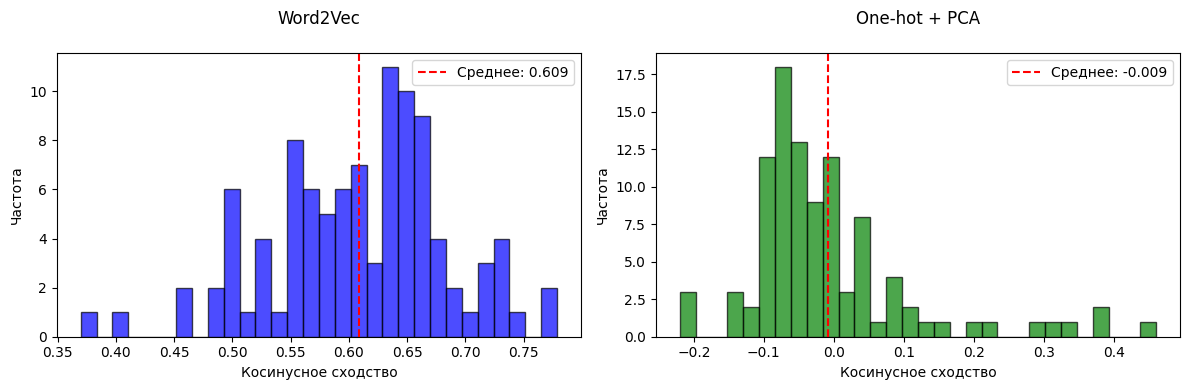

In [111]:

vectors_w2v = np.array(embeddings)

print(f"  Word2Vec:           {vectors_w2v.shape}")
print(f"  One-hot + PCA:      {vectors_onehot_pca.shape}")

def evaluate_vectors(vectors, method_name, num_pairs=100):
    np.random.seed(42)
    similarities = []
    
    for _ in range(num_pairs):
        idx1, idx2 = np.random.choice(len(vectors), 2, replace=False)
        sim = cosine_similarity(vectors[idx1], vectors[idx2])
        similarities.append(sim)
    
    similarities = np.array(similarities)
    
    print(f"\n{method_name}:")
    print(f"  mean sim: {similarities.mean():.4f}")
    print(f"  std sim:  {similarities.std():.4f}")
    print(f"  min/max:         {similarities.min():.4f} / {similarities.max():.4f}")
    print(f"  median:          {np.median(similarities):.4f}")
    
    return similarities

sim_w2v = evaluate_vectors(vectors_w2v, "Word2Vec")
sim_onehot_pca = evaluate_vectors(vectors_onehot_pca, "One-hot + PCA")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(sim_w2v, bins=30, alpha=0.7, edgecolor='black', color='blue')
axes[0].set_title('Word2Vec\n')
axes[0].set_xlabel('Косинусное сходство')
axes[0].set_ylabel('Частота')
axes[0].axvline(sim_w2v.mean(), color='red', linestyle='--', label=f'Среднее: {sim_w2v.mean():.3f}')
axes[0].legend()

axes[1].hist(sim_onehot_pca, bins=30, alpha=0.7, edgecolor='black', color='green')
axes[1].set_title('One-hot + PCA\n')
axes[1].set_xlabel('Косинусное сходство')
axes[1].set_ylabel('Частота')
axes[1].axvline(sim_onehot_pca.mean(), color='red', linestyle='--', label=f'Среднее: {sim_onehot_pca.mean():.3f}')
axes[1].legend()

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'method_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()